In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.fftpack import fft, fftfreq
from glob import glob
from os import path
from sys import stdout

# suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# interactive plots
# %matplotlib ipympl

In [2]:
import logging

logging.basicConfig(stream=stdout, level=logging.INFO, format='[%(levelname)s] %(message)s')
log = logging.getLogger()

In [3]:
csv_files = glob('Gyroscope*/Raw Data.csv')

trials = []
trials_meta = []

for file in csv_files:
    log.info(f"Processing '{file}' ...")
    data = pd.read_csv(file)
    datadir = path.dirname(file)

    # load time data
    time_data = pd.read_csv(path.join(datadir, 'meta/time.csv'))
    starts = time_data.loc[time_data['event'] == 'START', 'experiment time'].values
    pauses = time_data.loc[time_data['event'] == 'PAUSE', 'experiment time'].values

    # try to load segments data
    segments_file = path.join(datadir, 'meta/segments.csv')
    if path.isfile(segments_file):
        segments = pd.read_csv(segments_file)
    else:
        # no segments file => empty dataframe
        log.warning(f"cutoffs not found for '{datadir}'")
        segments = pd.DataFrame()

    # go through each segment of this file
    for i, (start, end) in enumerate(zip(starts, pauses)):
        # discard segments if specified
        if segments['keep'].values[i] == False:
            log.info(f'-> discarding segment {i}' )
            continue

        # if we have cutoff data, use it to crop the data
        # otherwise keep the whole segment
        if i in segments['segment'].values:
            start = segments.loc[i, 'start']
            end = segments.loc[i, 'end']

        mask = (data['Time (s)'] >= start) & (data['Time (s)'] <= end)
        trial = data.loc[mask]

        trials.append(trial)

        # get the comment if it exists
        comment = segments.loc[i, "comment"]
        if not pd.notna(comment): comment = None
        trials_meta.append((i, datadir, comment))

n_trials = len(trials)
log.info(f'Found {n_trials} trials in {len(csv_files)} files.')

[INFO] Processing 'Gyroscope rotation rate 2025-01-16 17-03-03/Raw Data.csv' ...
[INFO] Processing 'Gyroscope rotation rate 2025-01-16 17-10-11/Raw Data.csv' ...
[INFO] -> discarding segment 0
[INFO] Found 7 trials in 2 files.


[INFO] Trial 1: source 'Gyroscope rotation rate 2025-01-16 17-03-03' #0
[INFO] Comment: Intermediate axis rotation


<Figure size 640x480 with 0 Axes>

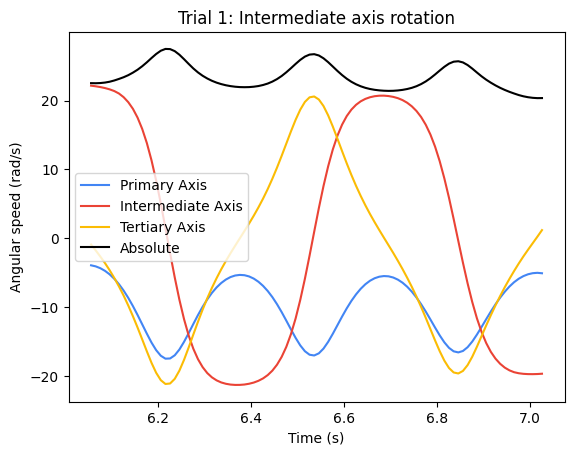

[INFO] Trial 2: source 'Gyroscope rotation rate 2025-01-16 17-10-11' #1
[INFO] Comment: Intermediate axis rotation


<Figure size 640x480 with 0 Axes>

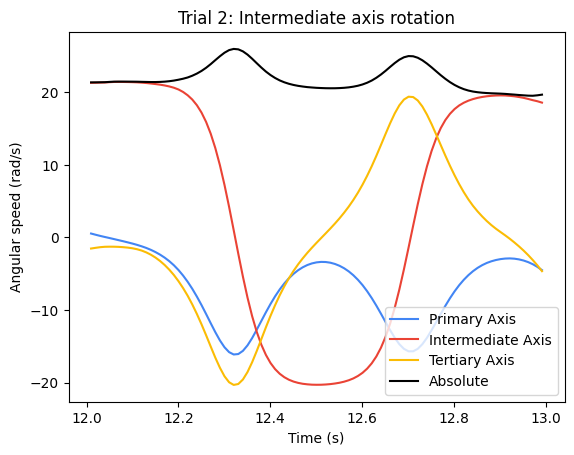

[INFO] Trial 3: source 'Gyroscope rotation rate 2025-01-16 17-10-11' #2
[INFO] Comment: Tertiary axis rotation


<Figure size 640x480 with 0 Axes>

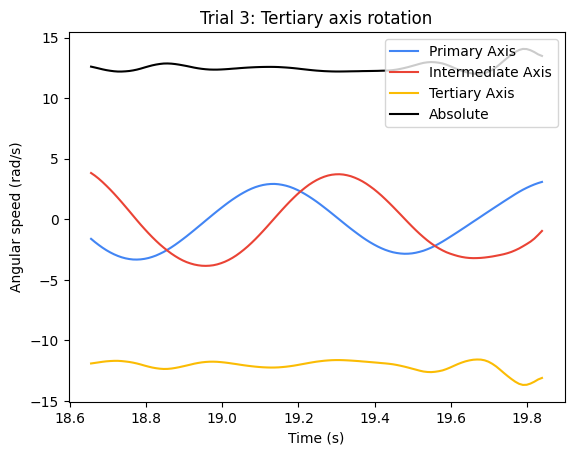

[INFO] Trial 4: source 'Gyroscope rotation rate 2025-01-16 17-10-11' #3
[INFO] Comment: Primary axis rotation


<Figure size 640x480 with 0 Axes>

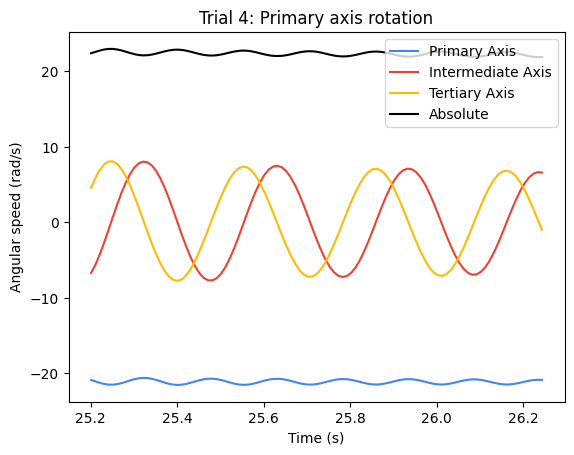

[INFO] Trial 5: source 'Gyroscope rotation rate 2025-01-16 17-10-11' #4
[INFO] Comment: Tertiary axis rotation


<Figure size 640x480 with 0 Axes>

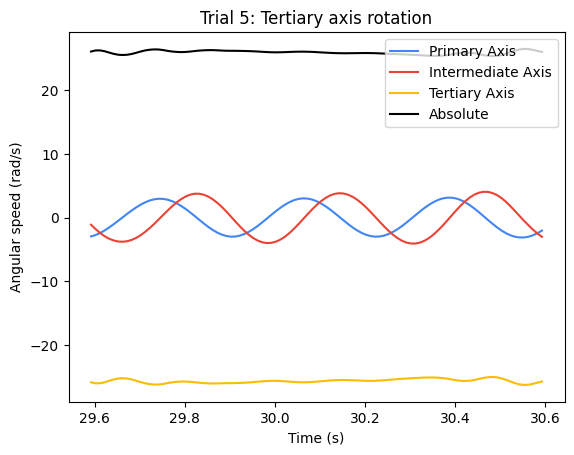

[INFO] Trial 6: source 'Gyroscope rotation rate 2025-01-16 17-10-11' #5
[INFO] Comment: Intermediate axis rotation


<Figure size 640x480 with 0 Axes>

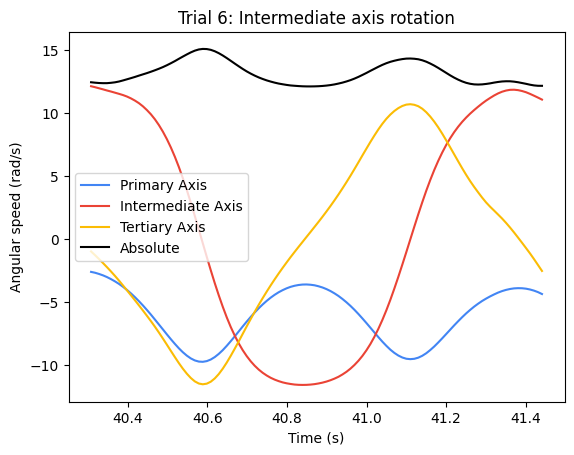

[INFO] Trial 7: source 'Gyroscope rotation rate 2025-01-16 17-10-11' #6
[INFO] Comment: Fast intermediate axis rotation


<Figure size 640x480 with 0 Axes>

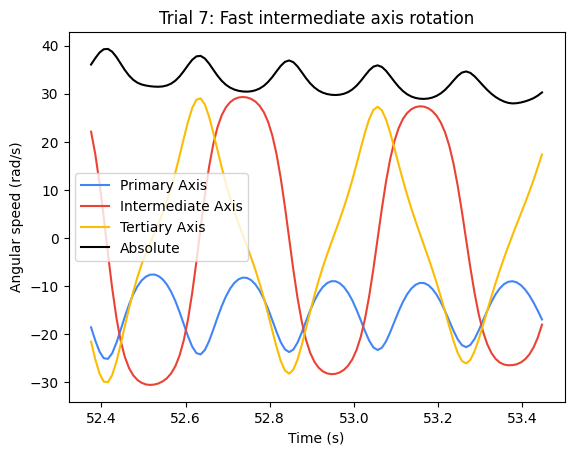

In [4]:
def plot_trial(i, x, y, z, a, ylabel):
    title = f'Trial {i+1}'

    # process metadata
    j, source, comment = trials_meta[i]
    log.info(f"{title}: source '{source}' #{j}")
    if comment:
        log.info(f'Comment: {comment}')
        title = f'{title}: {comment}'

    # make the plot
    plt.figure()
    ax = trials[i].plot(
        x='Time (s)',
        y=[z, x, y, a], # Iz > Ix > Iy
        color=['#4285f4', '#ea4335', '#fbbc04', 'black']
    )
    ax.legend([
        'Primary Axis',
        'Intermediate Axis',
        'Tertiary Axis',
        'Absolute'
    ])
    ax.set_ylabel(ylabel)
    plt.title(title)
    plt.show()


# angular speed params
w_label = 'Angular speed (rad/s)'
w_cols = [
    'Gyroscope x (rad/s)',
    'Gyroscope y (rad/s)',
    'Gyroscope z (rad/s)',
    'Absolute (rad/s)',
]

for i in range(n_trials):
    plot_trial(i, *w_cols, 'Angular speed (rad/s)')

[INFO] Trial 1: source 'Gyroscope rotation rate 2025-01-16 17-03-03' #0
[INFO] Comment: Intermediate axis rotation


<Figure size 640x480 with 0 Axes>

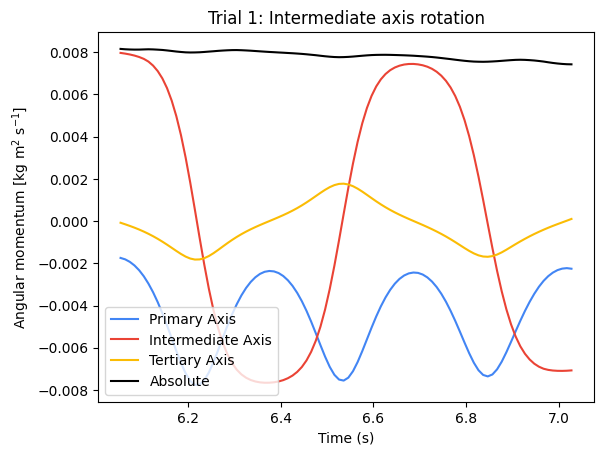

[INFO] Trial 2: source 'Gyroscope rotation rate 2025-01-16 17-10-11' #1
[INFO] Comment: Intermediate axis rotation


<Figure size 640x480 with 0 Axes>

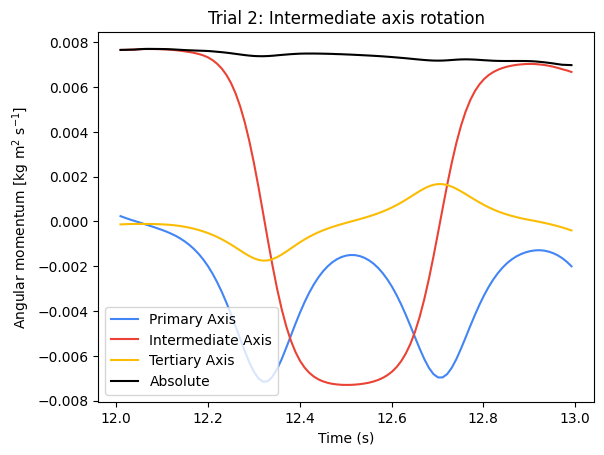

[INFO] Trial 3: source 'Gyroscope rotation rate 2025-01-16 17-10-11' #2
[INFO] Comment: Tertiary axis rotation


<Figure size 640x480 with 0 Axes>

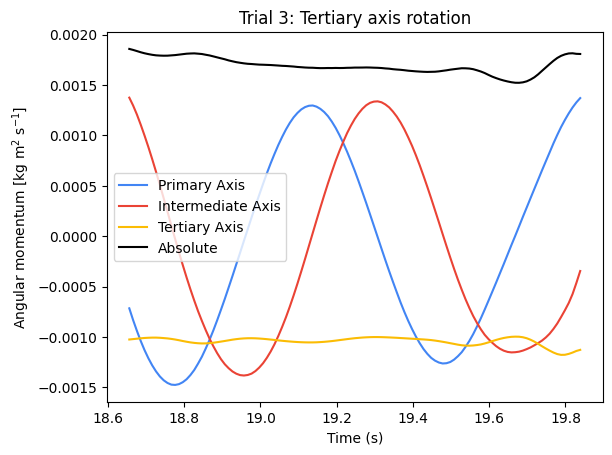

[INFO] Trial 4: source 'Gyroscope rotation rate 2025-01-16 17-10-11' #3
[INFO] Comment: Primary axis rotation


<Figure size 640x480 with 0 Axes>

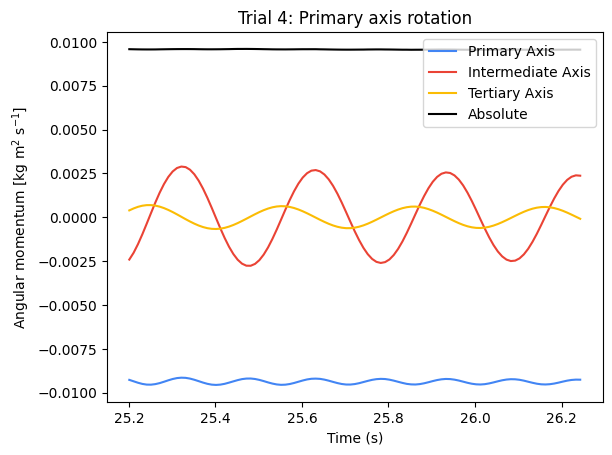

[INFO] Trial 5: source 'Gyroscope rotation rate 2025-01-16 17-10-11' #4
[INFO] Comment: Tertiary axis rotation


<Figure size 640x480 with 0 Axes>

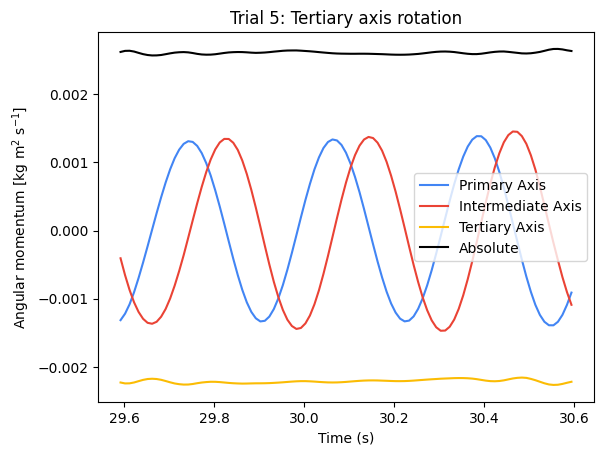

[INFO] Trial 6: source 'Gyroscope rotation rate 2025-01-16 17-10-11' #5
[INFO] Comment: Intermediate axis rotation


<Figure size 640x480 with 0 Axes>

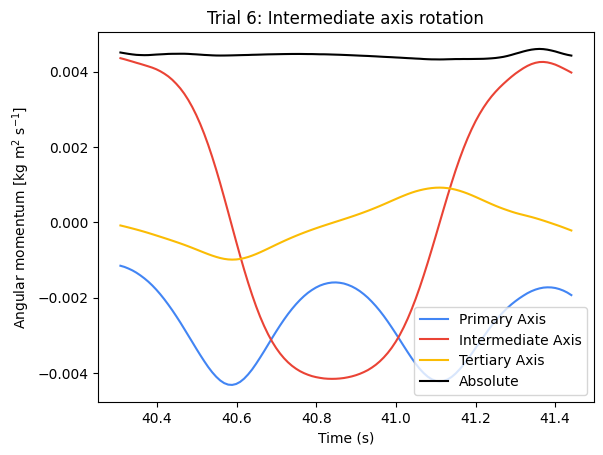

[INFO] Trial 7: source 'Gyroscope rotation rate 2025-01-16 17-10-11' #6
[INFO] Comment: Fast intermediate axis rotation


<Figure size 640x480 with 0 Axes>

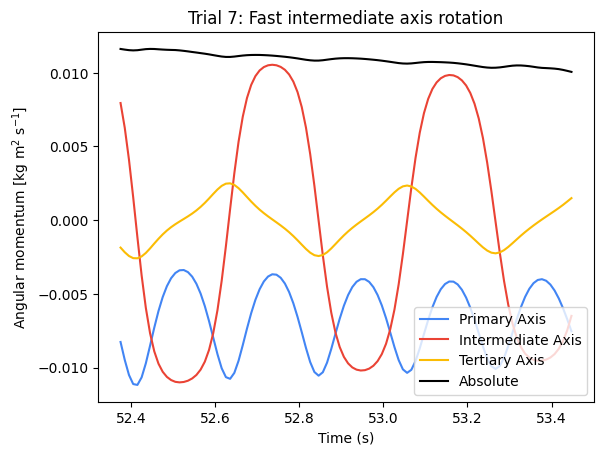

In [5]:
# physical dimensions
dims = np.array([71.5, 146.7, 7.4]) * 1e-3 # [m]
x, y, z = dims
vol = np.prod(dims) # [m^3]
mass = 0.200 # [kg]

# estimate the principal moments of inertia
c = 1/12
Ix = c * mass * (y**2 + z**2)
Iy = c * mass * (x**2 + z**2)
Iz = c * mass * (x**2 + y**2)

# add angular momentum columns to the trial data
for trial in trials:
    trial['Lx'] = trial.apply(lambda r: r['Gyroscope x (rad/s)'] * Ix, axis=1)
    trial['Ly'] = trial.apply(lambda r: r['Gyroscope y (rad/s)'] * Iy, axis=1)
    trial['Lz'] = trial.apply(lambda r: r['Gyroscope z (rad/s)'] * Iz, axis=1)
    trial['L'] = trial.apply(lambda r: np.linalg.norm((r['Lx'], r['Ly'], r['Lz'])), axis=1)

# angular momentum params
L_label = 'Angular momentum [kg m$^2$ s$^{-1}$]'
L_cols = ['Lx', 'Ly', 'Lz', 'L']

for i in range(n_trials):
    plot_trial(i, *L_cols, L_label)

In [6]:
def FFT(trial):
    wi = trial['Gyroscope x (rad/s)']

    N = len(wi)
    T = 1/100 # [s]

    yf = fft(wi.values)
    xf = fftfreq(N, T)[:N//2]   # positive frequencies
    magnitudes = abs(yf[:N//2]) # magnitude spectrum

    # identify dominant frequency
    dom_i = np.argmax(magnitudes)
    dom_freq = xf[dom_i]
    dom_mag = magnitudes[dom_i]

    # calculate peak-to-noise ratio
    noise_mag = np.delete(magnitudes, dom_i)
    noise_level = np.mean(noise_mag)
    peak_to_noise_ratio = dom_mag / noise_level if noise_level != 0 else np.inf
    period = 1 / dom_freq if dom_freq != 0 else np.inf

    return dom_freq, period, peak_to_noise_ratio


for trial, meta in zip(trials, trials_meta):
    j, src, comment = meta
    if 'intermediate' in comment.lower():
        dom_freq, period, ptn = FFT(trial)
        print()
        print(f'Results for segment {j} of {src}:')
        print(f"-> dominant frequency: {dom_freq:.2f} Hz")
        print(f"-> period: {period:.4f} seconds")
        print(f"-> peak-to-noise ratio: {ptn:.2f}")
        print()
    else:
        log.info(f"Skipping segment {j} of '{src}' ...")


Results for segment 0 of Gyroscope rotation rate 2025-01-16 17-03-03:
-> dominant frequency: 2.04 Hz
-> period: 0.4900 seconds
-> peak-to-noise ratio: 16.46


Results for segment 1 of Gyroscope rotation rate 2025-01-16 17-10-11:
-> dominant frequency: 1.01 Hz
-> period: 0.9900 seconds
-> peak-to-noise ratio: 45.43

[INFO] Skipping segment 2 of 'Gyroscope rotation rate 2025-01-16 17-10-11' ...
[INFO] Skipping segment 3 of 'Gyroscope rotation rate 2025-01-16 17-10-11' ...
[INFO] Skipping segment 4 of 'Gyroscope rotation rate 2025-01-16 17-10-11' ...

Results for segment 5 of Gyroscope rotation rate 2025-01-16 17-10-11:
-> dominant frequency: 0.88 Hz
-> period: 1.1400 seconds
-> peak-to-noise ratio: 123.06


Results for segment 6 of Gyroscope rotation rate 2025-01-16 17-10-11:
-> dominant frequency: 2.78 Hz
-> period: 0.3600 seconds
-> peak-to-noise ratio: 13.45

